In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def sub_pixel_creator(center, side_length, n_p):
    
    """Takes square centered at center = (x, y) with side_length = side length 
       (float) and divides it into n_p (integer) squares along each axis - so 
       returns n_p * n_p subsquares from the original square. In particular, 
       the function returns the coordinates of the centers of these subsquares,
       along with the final side length of the subsquare."""
     
    step_size = side_length / n_p
    leftmost_x = center[0] - side_length / 2
    lowest_y = center[1] - side_length / 2

    center_xs, center_ys = [], []
    center_x, center_y = leftmost_x + step_size / 2, lowest_y + step_size / 2
    for i in range(n_p):
        center_xs.append(center_x)
        center_ys.append(center_y)
        center_x += step_size
        center_y += step_size
    
    centers = list(itertools.product(center_xs, center_ys))
    new_side_length = step_size 
    return centers, new_side_length

Example: Partioning a 16 x 16 square centered at the origin into 4 equal subsquares:

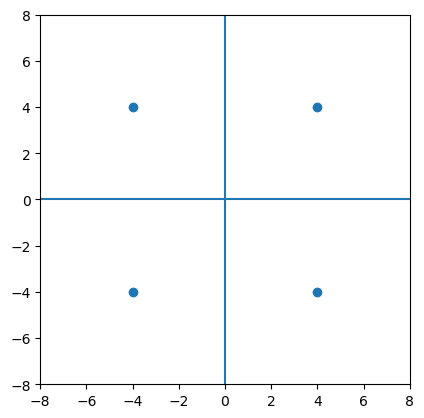

In [3]:
result = sub_pixel_creator((0,0), 16, 2)
centers = result[0]
new_side_length = result[1]
plt.scatter(*zip(*centers))

# commands to draw the squares themselves
plt.axhline(y = 0)
plt.axvline(x = 0)
    
ax = plt.gca()
plt.xlim(-8, 8)
plt.ylim(-8, 8)
ax.set_aspect('equal', adjustable='box')

Comment: The function above is well-suited to repeated application. See, for example, how we can divide each of the four subsquares above into four "subsubsquares" each: 

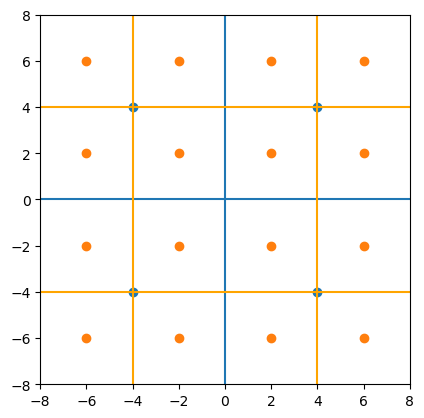

In [4]:
second_iteration_centers = []
for center in centers:
    result = sub_pixel_creator(center, new_side_length, 2)
    new_centers = result[0]
    second_iteration_centers.extend(new_centers) # note use "extend" instead of "append"
    
# recreating the above plot and plotting the new centers

plt.scatter(*zip(*centers))
plt.scatter(*zip(*second_iteration_centers))

# commands to draw the squares themselves

plt.axhline(y = 0)
plt.axvline(x = 0)

plt.axvline(x = -4, color = "orange")
plt.axvline(x = 4, color = "orange")
plt.axhline(y = -4, color = "orange")
plt.axhline(y = 4, color = "orange")
    
ax = plt.gca()
plt.xlim(-8, 8)
plt.ylim(-8, 8)
ax.set_aspect('equal', adjustable='box')

Let us now simulate and animate a stellar micro-lensing event with lenstronomy:

3.51015127388535


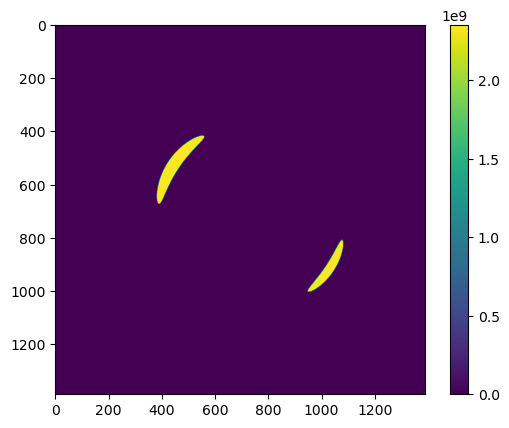

In [5]:
# define the microlens

d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc
M0 = 0.01  # mass of the lens in units of M_sol
diameter_s = 20 # size of the radius of the source star in units of the solar radius

# compute lensing properties

from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size
theta_E = einstein_radius(M0, d_l, d_s)
size_s = source_size(diameter_s, d_s)

# compute ray-tracing grid

grid_scale = size_s / 80
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)

from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

# compute unlensed surface brightness
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': 0, 'center_x': 0, 'center_y': 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)
ligth = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
surface_brightness = ligth.surface_brightness(beta_x, beta_y, kwargs_light)
unlensed_flux = np.sum(surface_brightness)


# compute surface brightness
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': theta_E / 4, 'center_y': theta_E / 6}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)
ligth = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
surface_brightness = ligth.surface_brightness(beta_x, beta_y, kwargs_light)
lensed_flux = np.sum(surface_brightness)

reference_magnification = lensed_flux / unlensed_flux
print(reference_magnification)

image = util.array2image(surface_brightness)
plt.imshow(image)
plt.colorbar()
plt.show()

# Description of the ABM (Meena et al. 2022)
Consider a stellar source of radius $\beta_s$ (say, in angular units, for instance) moving behind a gravitational lens, along a predetermined path in the source plane, which we assume here to be a square region for illustration purposes. The length of this path thus determines the area in the source plane that has to be modelled. This area defines the relevant area in the image plane. Once the area in the image plane is determined, it is divided into $n_p \times n_p$ pixels and each pixel is mapped to the source plane using the lens equation. Only those pixels in the image plane, which are mapped back to within $\Delta \beta$ from the source centre $(\beta_1, \beta_2)$, are secured for the next iteration. In the next iteration, each of the secured pixels is divided into new np × np subpixels to be mapped back to the source plane, while the source-plane boundary is also reduced by some pre-specified factor $\eta$, i.e. $\Delta \beta := \Delta \beta /\eta$, with $\eta > 1$. This recursive process goes on until $\Delta \beta$ is equal to the source size. In the end, we are left with a list of all the high-resolution image-plane pixels that map back to the source (note the pixel size of each image-plane pixel is now also of the order of the source size). The ratio between total area of the (micro) images in the image plane and the source area in the source plane gives the magnification of the source at this position.

In the following, we will use the $\tt{sub\_pixel\_creator}$ and $\tt{lenstronomy}$ methods used above to implement and validate the ABM.

In [6]:
L = theta_E * 4 # side length of square area in image plane - same as lenstronomy grid width
beta_0 = 4 * L # initial search radius - few times bigger than "necessary" to be safe
beta_s = size_s / 2 # factor of 1/2 because radius
n_p = 30
eta = 0.7 * n_p
source_position = (0, 0)

The number of iterations $N$ that the program should perform is given by

$$\beta_S = \frac{\beta_0}{\eta^{N-1}}.$$ 

In general, the above equation yields a non-integer solution for $N$. Thus, after solving for $N$, we define the number of iterations by

$$\# = \left \lceil 1 + \log_{\eta} \left(\frac{\beta_0}{\beta_S}\right) \right \rceil.$$

We note that for the final iteration, $\eta$ is adjusted such that $\eta := \eta^{N*}$, with $N*$ being the remainder defined by $N = \lfloor N \rfloor	+ N*$.

In [7]:
# helper functions 

def loop_information(eta, beta_0, beta_s):
    
    N = 1 + math.log((beta_0 / beta_s), eta)
    number_of_iterations = math.ceil(N)
    N_star = N - math.floor(N)
    final_eta = eta ** N_star 

    return number_of_iterations, final_eta

loop_info = loop_information(eta, beta_0, beta_s)
number_of_iterations = loop_info[0]
final_eta = loop_info[1]

def within_distance(center_point, test_point, threshold):
    
    distance = ((center_point[0] - test_point[0]) ** 2 + (center_point[1] - test_point[1]) ** 2) ** (1 / 2)
    if distance < threshold:
        return True
    else: 
        return False

In [8]:
def ABM(source_position, L, beta_0, beta_s, n_p, eta, number_of_iterations, final_eta, kwargs_lens):
    
    """Returns list of those high resolution image-plane pixels that were 
       mapped to within the radius β_s around the source position (β1, β2) 
       in the source plane."""
    
    total_number_of_rays_shot = 0
    i = 1
    centers = [(0, 0)]
    side_length = L
    delta_beta = beta_0
    while i < number_of_iterations:
        # print(delta_beta, i)
        running_list_of_new_centers = []
        for center in centers:
            source_coords = lens.ray_shooting(center[0], center[1], kwargs = kwargs_lens)
            total_number_of_rays_shot += 1
            if within_distance(source_coords, source_position, delta_beta):
                resultant_centers = sub_pixel_creator(center, side_length, n_p)[0]
                running_list_of_new_centers.extend(resultant_centers)
        centers = running_list_of_new_centers
    
        side_length /= n_p
        
        if i < number_of_iterations:
            delta_beta /= eta
        elif i == number_of_iterations:
            delta_beta /= final_eta
            
        i += 1
        
    final_centers = []
    for center in centers:
        source_coords = lens.ray_shooting(center[0], center[1], kwargs = kwargs_lens)
        total_number_of_rays_shot += 1
        if within_distance(source_coords, source_position, beta_s):
            final_centers.append(center)

    return final_centers, side_length, total_number_of_rays_shot

We calculate the magnification factor $\mu$ for the source at $(\beta_1, \beta_2)$ as the total multiple-image pixel area in the image plane, over the source area in the source plane. This is simply

$$\mu = \frac{n \ell^2}{ \pi \beta_s^2},$$

where $n$ is the total number of relevant pixels in the lens plane at the highest resolution (i.e. from the final iteration), and $\ell$ is their side length.

The ABM magnification is 3.50731650721445; the lenstronomy magnification is 3.51015127388535
ABM required 253801 computations. To attain this accuracy with simple IRS would require 810000 computations.


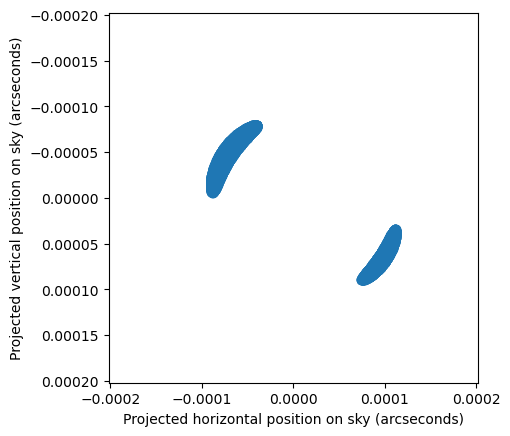

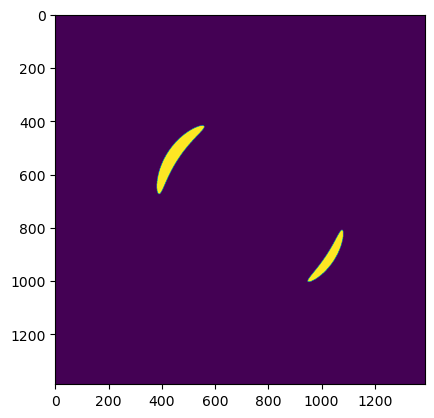

In [9]:
high_resolution_pixels = ABM((0,0), L, beta_0, beta_s, n_p, eta, number_of_iterations, final_eta,[{'theta_E': theta_E, 'center_x': theta_E / 4, 'center_y': theta_E / 6}])
n = len(high_resolution_pixels[0]) 
computed_magnification = (n * high_resolution_pixels[1] ** 2) / (math.pi * (beta_s ** 2)) 
plt.scatter(*zip(*high_resolution_pixels[0]))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.ylim(-2 * theta_E, 2 * theta_E)
plt.xlim(-2 * theta_E, 2 * theta_E)
plt.xlabel("Projected horizontal position on sky (arcseconds)")
plt.ylabel("Projected vertical position on sky (arcseconds)")
ax.invert_yaxis()
plt.figure()
plt.imshow(image)
print("The ABM magnification is " + str(computed_magnification) + "; the lenstronomy magnification is " + str(reference_magnification))
print("ABM required " + str(high_resolution_pixels[2]) + " computations. To attain this accuracy with simple IRS would require " + str(n_p ** 2 ** 2) + " computations.") 

A magnification formula is also given in Meena et al., and is implemented below for demonstration. However, it consistently gives incorrect results:

In [10]:
def magnification(n, beta_0, n_p, beta_s, eta):
    numerator = n * (beta_0 ** 2)
    N = 1 + math.log((beta_0 / beta_s), eta)
    denominator = n_p ** (2 * math.floor(N) + 2) * (math.pi * (beta_s ** 2))
    magnification = numerator / denominator
    return magnification

print(magnification(n, beta_0, n_p, beta_s, eta))

0.062352293461590214
